**GROUP 26:** <br>
- Andreia Bastos (20210604) <br>
- João Silva (20211104) <br>
- Tiago Quaresma (20210766) <br>
- Maria Pedrosa (20210863) <br> 
- Maria Inês Silva (20211027)


**Table of Contents** <br>
* [Import](#Import)
    * [Libraries And Functions](#librariesfunctions)
    * [Import Dataset](#dataset)
* [Initial Analysis](#initialanalysis)
* [Metric and Non-metric Features](#metnonmetfeatures)
* [Variables' Distribution](#Distribution)
    * [Categorical Variables - Histograms](#CatVarHist)
    * [Numeric Variables - Histograms](#NumVarHist)
    * [Numeric Variables - Boxplots](#NumVarBoxplot)
* [Variable Transformation](#TransformVar)
* [Coherence Checking](#Check)
* [Outlier Removal](#outlier)  
* [OneHotEncoder](#encoding) 
* [Target Split](#inputtarget)     
* [Feature Selection](#featureselection) 
    * [Correlation's: Spearman/Pearson](#corr)
    * [Chi-Square](#chisquare)
    * [Mutual Information](#mutualInfo)
    * [Recursive Feature Elimination - RFE](#rfe)
    * [LASSO Regression](#lasso)
    * [RIDGE Regression](#ridge)
    * [Feature Importances - Tree Based Classifiers](#featimportance)
* [Final Selected Features](#finalfeat)
* [Train Test Split](#traintestsplit)  
* [Scaling](#scaling)
* [Models](#modelling)
    * [Accuracy Scores](#Accuracy)
    * [F1 Scores](#F1)
    * [Random Forest](#rf)   
    * [Gradient Boosting Classifier](#gradBoost)
    * [Neural Network](#NN) 
    * [Stacking Classifier](#stacking)
* [SMOTE - Synthetic Minority Oversampling Technique](#smote)
* [ROC Curve](#roc)
* [Kaggle Submission](#kaggle)

    


<hr>
<a class="anchor" id="import">

## Import
    
</a>


<hr>
<a class="anchor" id="librariesfunctions">

### Libraries and functions 
    
</a>

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from math import ceil
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,balanced_accuracy_score, f1_score, plot_roc_curve
#--------------------------------Data Partition--------------------------------------

from sklearn.model_selection import train_test_split, GridSearchCV

#--------------------------------Scaling--------------------------------------
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer, quantile_transform

#--------------------------------Feature Selection--------------------------------------
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

#--------------------------------Model Selection--------------------------------------
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold

#--------------------------------Models --------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

#SMOTE
#from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import roc_curve


#=======================================Aux Functions=========================================

#These functions were all obtained from the practical classes with some modificaitons made 

def outliers(df,column):
    plt.figure(figsize=(12, 8))
    sns.boxplot(df[column])
    plt.xlabel(column)
    plt.title('Outliers of '+column)

def specificity(clf,cm):
  #cm is the confusion matrix
  FP = cm.sum(axis=0) - np.diag(cm)  #vector with nr of false positives of each label
  FN = cm.sum(axis=1) - np.diag(cm) #vector with nr of false negatives of each label
  TP = np.diag(cm) #vector with nr of true positives of each label
  TN = cm.sum() - (FP + FN + TP) #vector with nr of true negatives of each label

  FP = FP.astype(float)
  TN = TN.astype(float)
  
  sp = TN/(TN+FP) #vector with specificity of each label
  sp_mean = np.mean(sp)
  labels=clf.classes_
  res = "\n".join("{:>25} "     " {}".format(x, y) for x, y in zip(labels, sp))
  print(res)
  print('\nmacro avg:', sp_mean)

def metrics(model, X_train, y_train , X_val, y_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_train,model.predict(X_train))))
    print('Balanced Accuracy Score: {0:.4f}\n'.format(balanced_accuracy_score(y_train,model.predict(X_train))))
    print('Classification Report:\n{}\n'.format(classification_report(y_train, model.predict(X_train))))
    print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_train, model.predict(X_train))))
    print("Specificity:\n") 
    print(specificity(model,confusion_matrix(y_train,model.predict(X_train))))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_val,model.predict(X_val))))
    print('Balanced Accuracy Score: {0:.4f}\n'.format(balanced_accuracy_score(y_val,model.predict(X_val))))
    print('Classification Report:\n{}\n'.format(classification_report(y_val, model.predict(X_val))))
    print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_val, model.predict(X_val))))
    print("Specificity:\n")  
    print(specificity(model,confusion_matrix(y_val,model.predict(X_val))))
    

def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X_train_o, y_train_o)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    

<a class="anchor" id="dataset">

## Import Dataset
    
</a>

In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

train_original = train.copy()
test_original = test.copy()

<a class="anchor" id="initialanalysis">

## Initial Analysis


</a>

In [4]:
train.shape

(9999, 17)

In [5]:
test.shape

(2300, 16)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   2300 non-null   int64  
 1   Date                        2300 non-null   object 
 2   AccountMng_Pages            2300 non-null   int64  
 3   AccountMng_Duration         2300 non-null   float64
 4   FAQ_Pages                   2300 non-null   int64  
 5   FAQ_Duration                2300 non-null   float64
 6   Product_Pages               2300 non-null   int64  
 7   Product_Duration            2300 non-null   float64
 8   GoogleAnalytics_BounceRate  2300 non-null   float64
 9   GoogleAnalytics_ExitRate    2300 non-null   float64
 10  GoogleAnalytics_PageValue   2300 non-null   float64
 11  OS                          2300 non-null   object 
 12  Browser                     2300 non-null   int64  
 13  Country                     2300 

In [8]:
#set the User ID as the index
#train.set_index('Access_ID', inplace = True)
#test.set_index('Access_ID', inplace = True)

- We also checked for duplicated rows but found none

In [9]:
strange_values_list = ["!","$","%","?","*","+","_","@","€"," ","{",""]
train.replace(strange_values_list,np.nan,inplace=True)
train.isna().sum()

Access_ID                     0
Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
Buy                           0
dtype: int64

In [10]:
test.replace(strange_values_list,np.nan,inplace=True)
test.isna().sum()

Access_ID                     0
Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
dtype: int64

In [11]:
train.head()


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [12]:
test.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor
0,798519314,24-Aug-20,0,0.00,0,0.0,86,5332.5478,0.0139,0.0654,0.0000,Windows,2,Brazil,1,Returner
1,798663101,25-May-20,2,37.50,0,0.0,55,1420.4725,0.0012,0.0058,0.0000,Android,1,Spain,4,Returner
2,798663221,2-Nov-20,0,0.00,0,0.0,36,788.5000,0.0000,0.0250,0.0000,Windows,6,Spain,3,Returner
3,798760918,14-May-20,0,0.00,0,0.0,2,689.0000,0.0000,0.1000,0.0000,Windows,2,Spain,2,New_Access
4,798856982,5-Nov-20,12,225.25,1,0.0,129,3367.0413,0.0014,0.0185,1.0353,Windows,4,Portugal,10,Returner


- As we can see from the table above, the minimum and maximum values of the variables are discrepant, which may require standardization.

In [13]:
train.corr()

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic,Buy
Access_ID,1.000000,-0.005099,-0.012307,-0.002114,0.003469,-0.002264,-0.003826,0.003329,0.003874,-0.013560,-0.009459,-0.009252,-0.004103
AccountMng_Pages,-0.005099,1.000000,0.607348,0.383062,0.256978,0.427517,0.368118,-0.224157,-0.317452,0.098760,-0.024604,-0.031529,0.136236
AccountMng_Duration,-0.012307,0.607348,1.000000,0.306807,0.243544,0.297512,0.368208,-0.145261,-0.206124,0.062708,-0.016848,-0.016647,0.094645
FAQ_Pages,-0.002114,0.383062,0.306807,1.000000,0.619495,0.388860,0.392125,-0.116902,-0.164793,0.045593,-0.038452,-0.033569,0.092508
FAQ_Duration,0.003469,0.256978,0.243544,0.619495,1.000000,0.286298,0.361224,-0.075673,-0.107378,0.029710,-0.017126,-0.020748,0.067509
Product_Pages,-0.002264,0.427517,0.297512,0.388860,0.286298,1.000000,0.857664,-0.205078,-0.292165,0.052234,-0.015524,-0.035120,0.153968
Product_Duration,-0.003826,0.368118,0.368208,0.392125,0.361224,0.857664,1.000000,-0.182305,-0.247934,0.047423,-0.011621,-0.028101,0.146043
GoogleAnalytics_BounceRate,0.003329,-0.224157,-0.145261,-0.116902,-0.075673,-0.205078,-0.182305,1.000000,0.913050,-0.119419,-0.008190,0.074765,-0.151626
GoogleAnalytics_ExitRate,0.003874,-0.317452,-0.206124,-0.164793,-0.107378,-0.292165,-0.247934,0.913050,1.000000,-0.174556,0.002872,0.075640,-0.207968
GoogleAnalytics_PageValue,-0.013560,0.098760,0.062708,0.045593,0.029710,0.052234,0.047423,-0.119419,-0.174556,1.000000,0.046219,0.004532,0.486579


In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Access_ID,9999.0,4.519728e+08,2.024990e+08,102863333.0,2.731950e+08,4.536169e+08,6.259756e+08,7.984440e+08
AccountMng_Pages,9999.0,2.324232e+00,3.340676e+00,0.0,0.000000e+00,1.000000e+00,4.000000e+00,2.700000e+01
AccountMng_Duration,9999.0,8.120585e+01,1.797155e+02,0.0,0.000000e+00,7.500000e+00,9.220835e+01,3.398750e+03
FAQ_Pages,9999.0,5.080508e-01,1.279390e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01
FAQ_Duration,9999.0,3.455910e+01,1.397970e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.549375e+03
Product_Pages,9999.0,3.168587e+01,4.455028e+01,0.0,7.000000e+00,1.800000e+01,3.800000e+01,7.050000e+02
Product_Duration,9999.0,1.199769e+03,1.958276e+03,0.0,1.835625e+02,5.990000e+02,1.470271e+03,6.397352e+04
GoogleAnalytics_BounceRate,9999.0,2.230545e-02,4.877597e-02,0.0,0.000000e+00,3.200000e-03,1.680000e-02,2.000000e-01
GoogleAnalytics_ExitRate,9999.0,4.318147e-02,4.884528e-02,0.0,1.430000e-02,2.510000e-02,5.000000e-02,2.000000e-01
GoogleAnalytics_PageValue,9999.0,5.963120e+00,1.875363e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.617637e+02


In [15]:
test.corr()

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,Type_of_Traffic
Access_ID,1.000000,0.010065,0.002288,-0.015014,-0.003667,0.008162,0.017520,0.015732,0.015374,-0.018198,-0.031092,0.007898
AccountMng_Pages,0.010065,1.000000,0.574046,0.348412,0.251891,0.447415,0.405094,-0.221398,-0.312199,0.098913,-0.024228,-0.041360
AccountMng_Duration,0.002288,0.574046,1.000000,0.282003,0.213269,0.250055,0.287925,-0.139744,-0.205056,0.090585,-0.006642,-0.007295
FAQ_Pages,-0.015014,0.348412,0.282003,1.000000,0.617129,0.308728,0.366166,-0.112760,-0.159114,0.056831,-0.035349,-0.032018
FAQ_Duration,-0.003667,0.251891,0.213269,0.617129,1.000000,0.254892,0.287854,-0.067516,-0.096763,0.033026,-0.026918,-0.045220
Product_Pages,0.008162,0.447415,0.250055,0.308728,0.254892,1.000000,0.883106,-0.202555,-0.294106,0.076406,-0.002380,-0.059732
Product_Duration,0.017520,0.405094,0.287925,0.366166,0.287854,0.883106,1.000000,-0.197446,-0.274259,0.080116,0.012895,-0.056798
GoogleAnalytics_BounceRate,0.015732,-0.221398,-0.139744,-0.112760,-0.067516,-0.202555,-0.197446,1.000000,0.912664,-0.119918,-0.054056,0.108113
GoogleAnalytics_ExitRate,0.015374,-0.312199,-0.205056,-0.159114,-0.096763,-0.294106,-0.274259,0.912664,1.000000,-0.175572,-0.045673,0.107215
GoogleAnalytics_PageValue,-0.018198,0.098913,0.090585,0.056831,0.033026,0.076406,0.080116,-0.119918,-0.175572,1.000000,0.046112,0.005640


In [16]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Access_ID,2300.0,8.804779e+08,4.702750e+07,798519314.0,8.401491e+08,8.804244e+08,9.208468e+08,9.622187e+08
AccountMng_Pages,2300.0,2.290000e+00,3.252300e+00,0.0,0.000000e+00,1.000000e+00,4.000000e+00,2.300000e+01
AccountMng_Duration,2300.0,7.978093e+01,1.644476e+02,0.0,0.000000e+00,8.550000e+00,9.785000e+01,2.720500e+03
FAQ_Pages,2300.0,4.865217e-01,1.234311e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01
FAQ_Duration,2300.0,3.426683e+01,1.455007e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.252033e+03
Product_Pages,2300.0,3.192870e+01,4.415023e+01,0.0,8.000000e+00,1.800000e+01,3.800000e+01,5.340000e+02
Product_Duration,2300.0,1.172039e+03,1.702731e+03,0.0,1.868750e+02,5.986893e+02,1.439535e+03,1.850413e+04
GoogleAnalytics_BounceRate,2300.0,2.170235e-02,4.721379e-02,0.0,0.000000e+00,2.900000e-03,1.675000e-02,2.000000e-01
GoogleAnalytics_ExitRate,2300.0,4.256478e-02,4.753867e-02,0.0,1.427500e-02,2.520000e-02,5.000000e-02,2.000000e-01
GoogleAnalytics_PageValue,2300.0,5.588465e+00,1.778171e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.585499e+02


In [17]:
train.dtypes

Access_ID                       int64
Date                           object
AccountMng_Pages                int64
AccountMng_Duration           float64
FAQ_Pages                       int64
FAQ_Duration                  float64
Product_Pages                   int64
Product_Duration              float64
GoogleAnalytics_BounceRate    float64
GoogleAnalytics_ExitRate      float64
GoogleAnalytics_PageValue     float64
OS                             object
Browser                         int64
Country                        object
Type_of_Traffic                 int64
Type_of_Visitor                object
Buy                             int64
dtype: object

<a class="anchor" id="#metnonmetfeatures">

## Metric and Non Metric features
</a>

In [18]:
non_metric_features = [ "OS", "Country", "Type_of_Visitor","Browser", "Type_of_Traffic", "Date"]
metric_features = train.columns.drop(non_metric_features).to_list()
metric_features.remove('Buy')
metric_features.remove('Access_ID')


<a class="anchor" id="#Distribution">

## Variables' Distribution
</a>
    



In [19]:
train_copy = train.copy()
test_copy =test.copy()

<a class="anchor" id="#CatVarHist">

### Categorical Variable Histograms
</a>

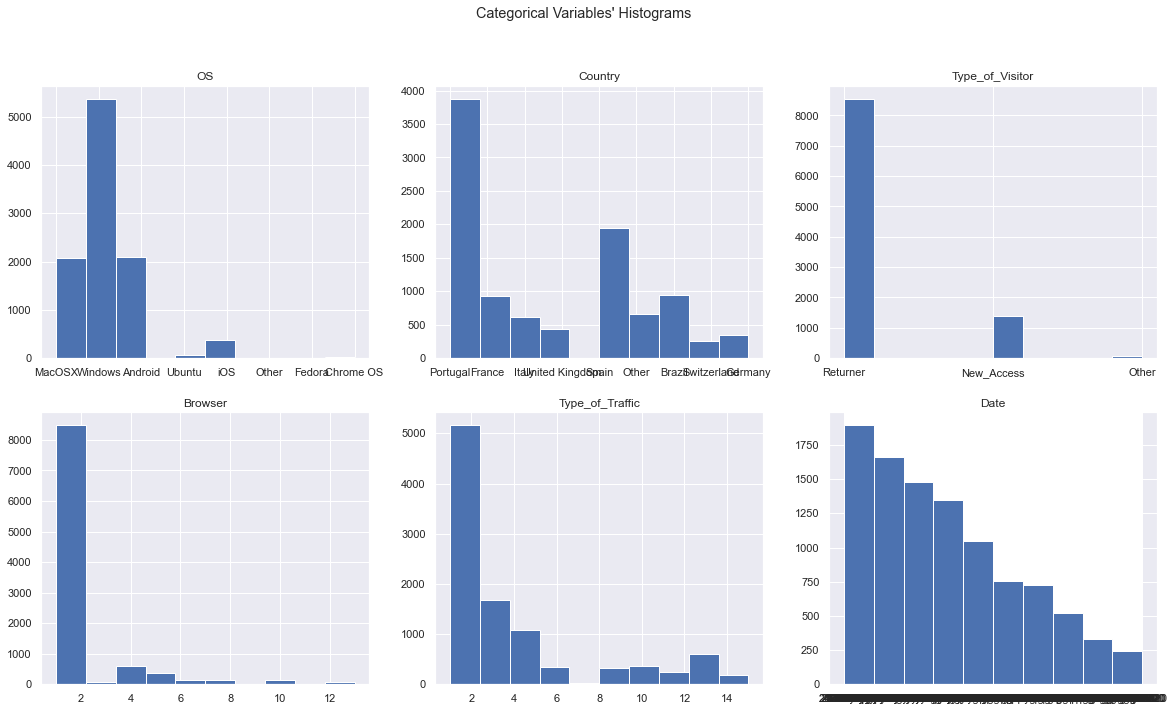

In [20]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.hist(train_copy[feat])
    ax.set_title(feat, y=1)
    
# Layout
# Add a centered title to the figure:
title = " Categorical Variables' Histograms"

plt.suptitle(title)
plt.show()

<a class="anchor" id="#NumVarHist">

### Numerical Variable Histograms

</a>

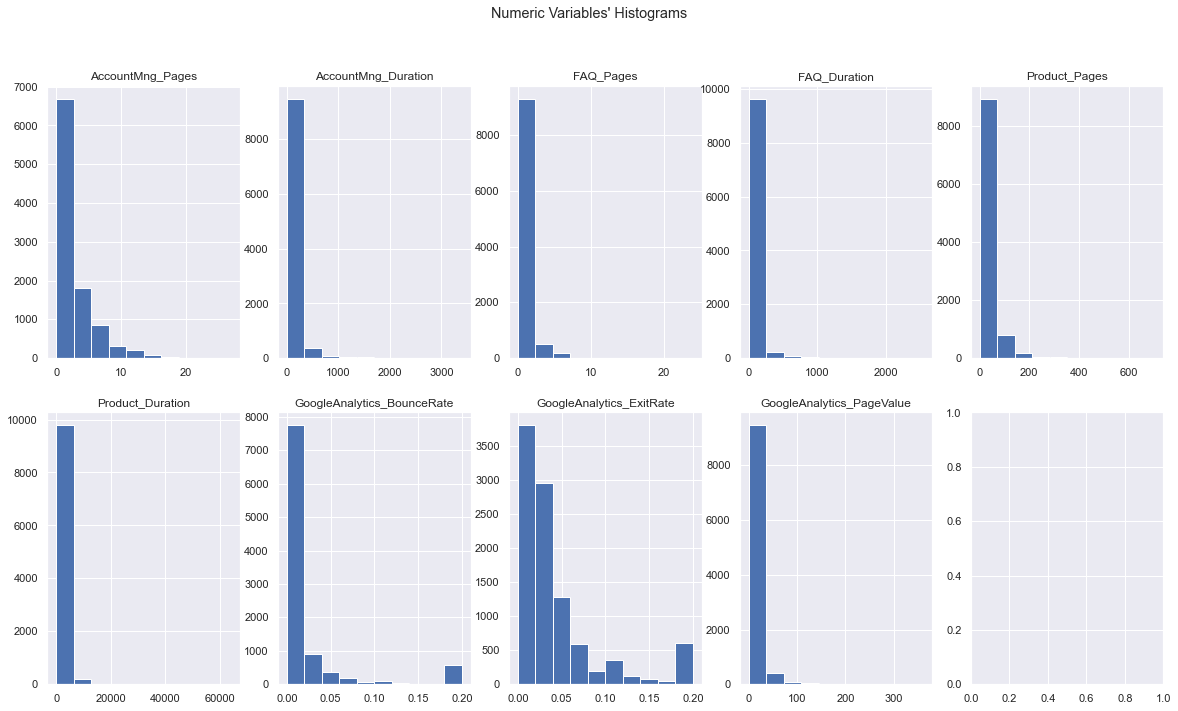

In [21]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(train_copy[feat])
    ax.set_title(feat, y=1)
    
# Layout
# Add a centered title to the figure:
title = " Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

<a class="anchor" id="#NumVarBoxplot">

### Numerical Variable BoxPlots
    
</a >

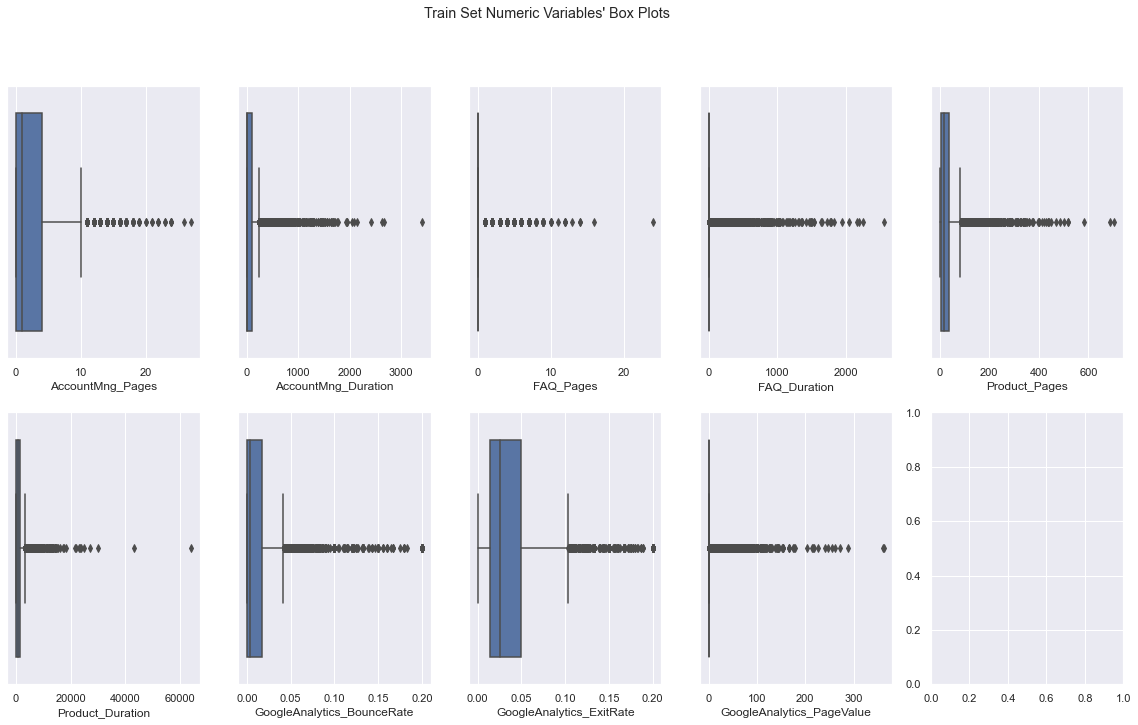

In [22]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=train_copy[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Train Set Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()


<a class="anchor" id="#TransformVar">

## Variable Transformation
</a>


In [23]:
#log = ['GoogleAnalytics_ExitRate', 'AccountMng_Duration', 'AccountMng_Pages', 'Product_Pages', 'Product_Duration']
#scale = train_copy.columns.drop(log).to_list()
#scale.remove('Buy')
#scale.remove('Month')
#scale.remove('Access_ID')
#scale.remove('Browser')
#scale.remove('Country')
#scale.remove('OS')
#scale.remove('Type_of_Traffic')
#scale.remove('Type_of_Visitor')

#pt = PowerTransformer()
#train_copy[log] = pd.DataFrame(
 #   pt.fit_transform(train_copy[log]), columns=log
#)
#train_copy.replace(np.nan,0, inplace = True)
#train_copy[log].hist(figsize=(14, 14));

#SQRT transformation
#sqrt = ['GoogleAnalytics_ExitRate', 'AccountMng_Duration', 'AccountMng_Pages', 'Product_Pages', 'Product_Duration']
#scale = train_copy.columns.drop(log).to_list()
#scale.remove('Buy')
#scale.remove('Month')
#scale.remove('Access_ID')
#scale.remove('Browser')
#scale.remove('Country')
#scale.remove('OS')
#scale.remove('Type_of_Traffic')
#scale.remove('Type_of_Visitor')

#train_copy[sqrt] = np.sqrt(train_copy[sqrt])
#test_copy[sqrt] = np.sqrt(test_copy[sqrt])

#histogram showing the vriables after applying the square root transformation
#train_copy[sqrt].hist(figsize=(14, 14))
#plt.show()

In [24]:
#TRAIN
train_copy['Date'] = pd.to_datetime(train_copy['Date'])
train_copy['Month'] = train_copy['Date'].dt.month
train_copy.drop(['Date'], axis = 1, inplace = True)
#TEST
test_copy['Date'] = pd.to_datetime(test_copy['Date'])
test_copy['Month'] = test_copy['Date'].dt.month
test_copy.drop(['Date'], axis = 1, inplace = True)

#update non metric features
non_metric_features = [ "OS", "Country", "Type_of_Visitor","Browser", "Type_of_Traffic", "Month"]


<a class="anchor" id="#Check">

## Coherence Check

</a>


In [25]:
#TRAIN
train_copy['AccountMng_Duration'].mask((train_copy['AccountMng_Pages'] != 0) & (train_copy['AccountMng_Duration'] == 0), train_copy['AccountMng_Duration'].median(), inplace=True)
#train_copy[(train_copy['AccountMng_Pages'] == 0) & (train_copy['AccountMng_Duration'] != 0)]
train_copy['FAQ_Duration'].mask((train_copy['FAQ_Pages'] != 0) & (train_copy['FAQ_Duration'] == 0), train_copy['FAQ_Duration'].mean(), inplace=True)
#train_copy[(train_copy['FAQ_Pages'] == 0) & (train_copy['FAQ_Duration'] != 0)]
train_copy['Product_Duration'].mask((train_copy['Product_Pages'] != 0) & (train_copy['Product_Duration'] == 0), train_copy['Product_Duration'].median(), inplace=True)
#train_copy[(train_copy['Product_Pages'] == 0) & (train_copy['Product_Duration'] != 0

#TEST
test_copy['AccountMng_Duration'].mask((test_copy['AccountMng_Pages'] != 0) & (test_copy['AccountMng_Duration'] == 0), test_copy['AccountMng_Duration'].median(), inplace=True)
#test_copy[(test_copy['AccountMng_Pages'] == 0) & (test_copy['AccountMng_Duration'] != 0)]
test_copy['FAQ_Duration'].mask((test_copy['FAQ_Pages'] != 0) & (test_copy['FAQ_Duration'] == 0), test_copy['FAQ_Duration'].mean(), inplace=True)
#test_copy[(test_copy['FAQ_Pages'] == 0) & (test_copy['FAQ_Duration'] != 0)]
test_copy['Product_Duration'].mask((test_copy['Product_Pages'] != 0) & (test_copy['Product_Duration'] == 0), test_copy['Product_Duration'].median(), inplace=True)


In [26]:
metric_features = ['AccountMng_Duration','AccountMng_Pages','FAQ_Duration','FAQ_Pages','Product_Pages','Product_Duration','GoogleAnalytics_BounceRate',
                   'GoogleAnalytics_ExitRate','GoogleAnalytics_PageValue']

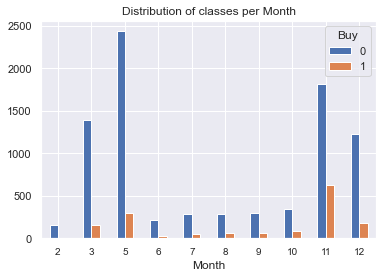

In [27]:
data1=train_copy.groupby(['Month', 'Buy']).size().to_frame('Count').reset_index()
data1.pivot("Month", "Buy", "Count").plot(kind='bar')
plt.title('Distribution of classes per Month')
plt.xticks(rotation=0, fontsize=10)
plt.show()

In [28]:
train_copy.groupby('Buy').count()

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month
Buy,,,,,,,,,,,,,,,,
0,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447,8447
1,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552,1552


<a class="anchor" id="#outlier">

## Outliers Removal 

</a>



In [29]:
# save a copy of the train set before removing the outliers
df_outliers = train_copy.copy()

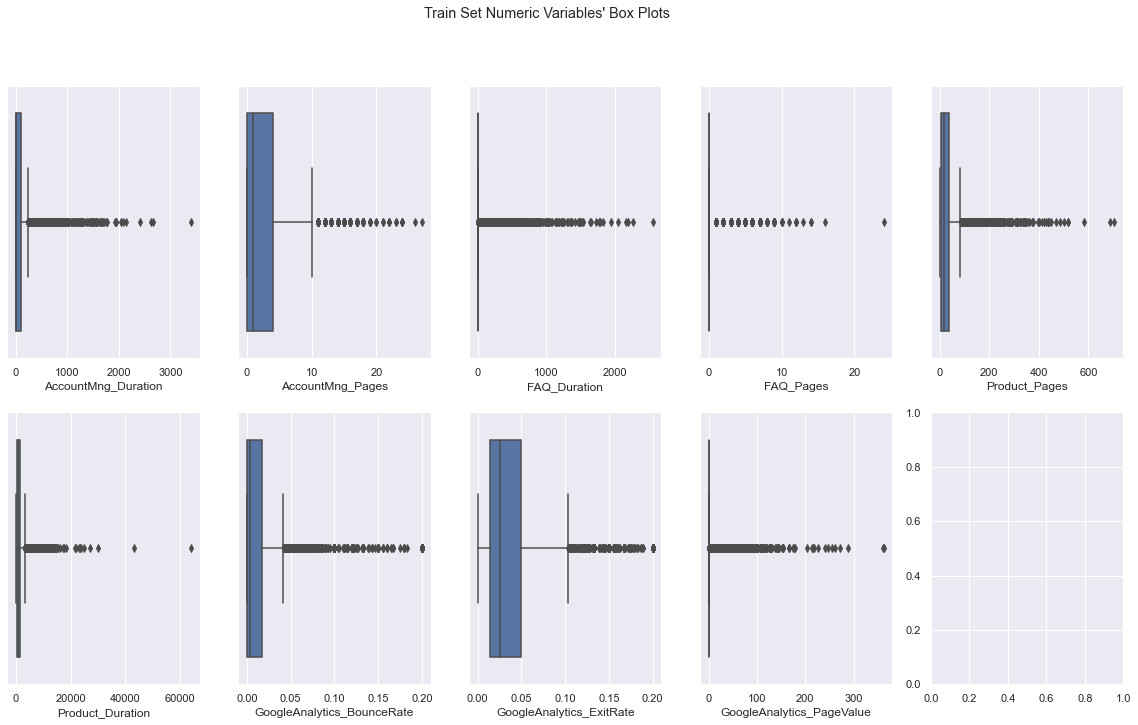

In [30]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=train_copy[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Train Set Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [31]:
filters1 = (
    ((train_copy['AccountMng_Duration'] <= 3900))
    &
    ((train_copy['FAQ_Duration'] <= 2900))
    &
    ((train_copy['FAQ_Pages'] <= 29))
    &
    ((train_copy['GoogleAnalytics_PageValue'] <= 350))
    &
    ((train_copy['Product_Duration'] <= 50000))
)
df_1 = train_copy[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / train_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.9997


In [32]:
amf_mean = train_copy['AccountMng_Duration'].mean()
amf_std = train_copy['AccountMng_Duration'].std()

filters2 = (
    (train_copy['AccountMng_Duration'] < amf_mean + 5 * amf_std)
    &
    (train_copy['FAQ_Duration'] < train_copy['FAQ_Duration'].mean() + 5*train_copy['FAQ_Duration'].std())
    &
    (train_copy['FAQ_Pages'] < train_copy['FAQ_Pages'].mean() + 5*train_copy['FAQ_Pages'].std())
    & 
    (train_copy['GoogleAnalytics_PageValue'] < train_copy['GoogleAnalytics_PageValue'].mean() + 5*train_copy['GoogleAnalytics_PageValue'].std())
    & 
    (train_copy['Product_Duration'] < train_copy['Product_Duration'].mean() + 5*train_copy['Product_Duration'].std())

) 

df_2 = train_copy[filters2]


print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / train_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.9677


In [33]:
q25 = train_copy.quantile(.25)
q75 = train_copy.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters3 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters3.append(train_copy[metric].between(llim, ulim, inclusive=True))

filters3 = pd.Series(np.all(filters3, 0), index=train_copy.index)
df_3 = train_copy[filters3]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / train_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.4725


C:\Users\silva\AppData\Local\Temp/ipykernel_2556/2824182240.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  filters3.append(train_copy[metric].between(llim, ulim, inclusive=True))


In [34]:
df_4 = train_copy[(filters1 | filters2 | filters3)]
print('Percentage of data kept after removing outliers:', np.round(df_4.shape[0] / train_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.9997


In [35]:
train_copy = df_4.copy()

- We keep the first filtering because IQR is not useful in our very sparse dataset

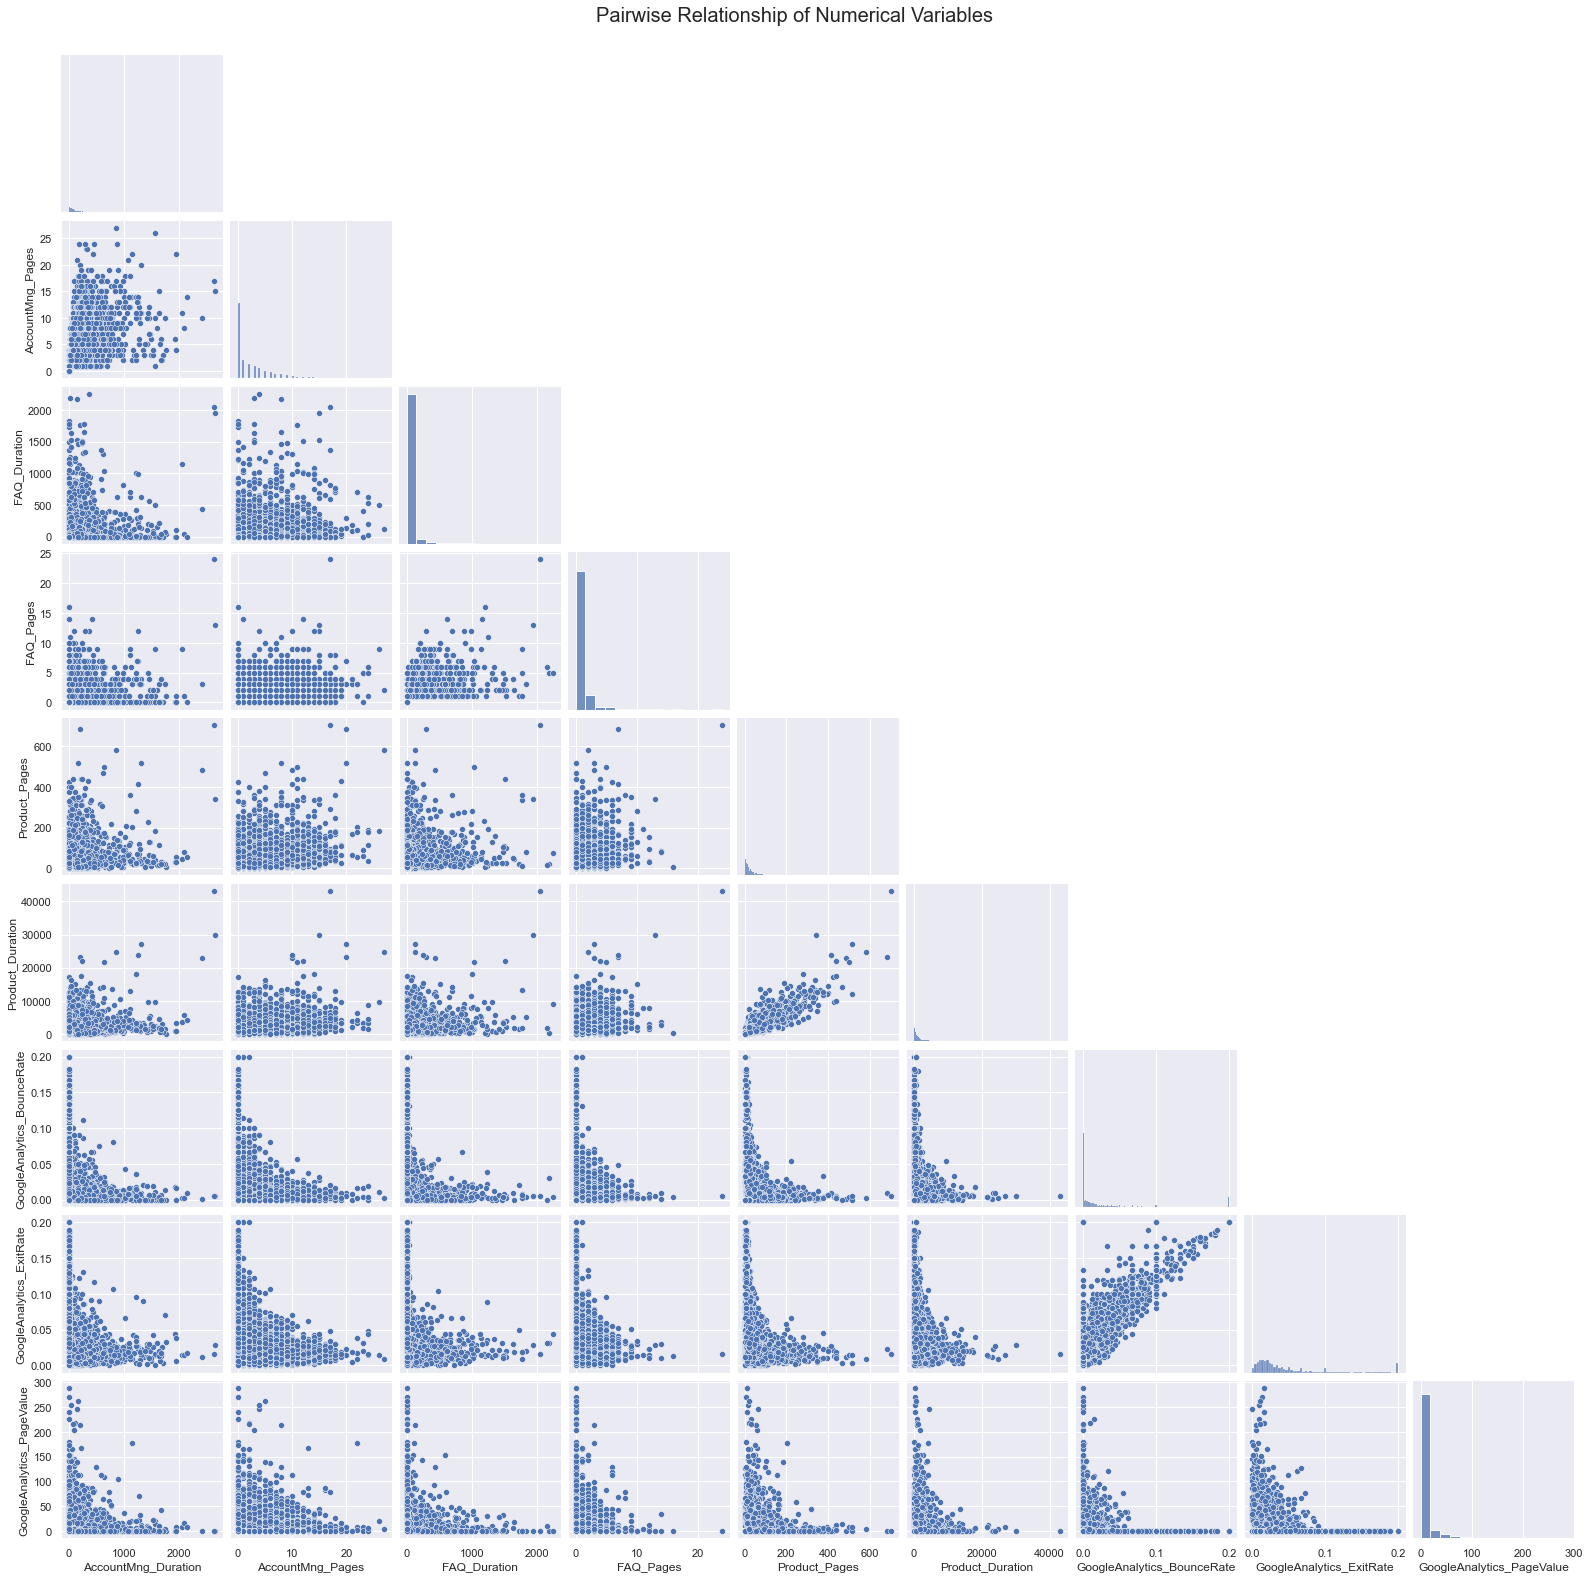

In [36]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(train_copy[metric_features], diag_kind="hist", corner=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

<a class="anchor" id="#encoding">

## One Hot Encoding  

</a>


In [37]:
non_metric_features

['OS', 'Country', 'Type_of_Visitor', 'Browser', 'Type_of_Traffic', 'Month']

In [38]:
ohc = OneHotEncoder(sparse=False,drop = 'first')
ohc_feat = ohc.fit_transform(train_copy[non_metric_features])
ohc_feat_names = ohc.get_feature_names(non_metric_features)
ohc_df = pd.DataFrame(ohc_feat, columns = ohc_feat_names, index = train_copy.index)
train_copy = pd.concat([train_copy.drop(columns=non_metric_features), ohc_df], axis=1)


In [39]:
train_copy

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,...,Type_of_Traffic_15,Month_3,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,102863333,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103117814,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103201891,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,103226087,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,103234445,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,798314158,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9996,798339820,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,798371242,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
ohc = OneHotEncoder(sparse=False,drop = 'first')
ohc_feat = ohc.fit_transform(df_outliers[non_metric_features])
ohc_feat_names = ohc.get_feature_names(non_metric_features)
ohc_df = pd.DataFrame(ohc_feat, columns = ohc_feat_names, index = df_outliers.index)
df_outliers = pd.concat([df_outliers.drop(columns=non_metric_features), ohc_df], axis=1)


In [41]:
df_outliers

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,...,Type_of_Traffic_15,Month_3,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,102863333,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103117814,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103201891,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,103226087,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,103234445,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,798314158,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9996,798339820,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,798371242,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
ohc = OneHotEncoder(sparse=False,drop = 'first')
ohc_feat = ohc.fit_transform(test_copy[non_metric_features])
ohc_feat_names = ohc.get_feature_names(non_metric_features)
ohc_df = pd.DataFrame(ohc_feat, columns = ohc_feat_names, index = test_copy.index)
test_copy = pd.concat([test_copy.drop(columns=non_metric_features), ohc_df], axis=1)


<a class="anchor" id="#inputtarget">

## Target Split



</a>



In [43]:
target = train_copy.Buy

train_split = train_copy.drop('Buy', axis =1 )

<a class="anchor" id="#featureselection">


## Feature Selection



</a>



<a class="anchor" id="#corr">

### Spearman/Pearson

</a>


In [44]:
def cor_heatmap(cor):
    plt.figure(figsize=(10,8))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [45]:
#separate the categorical data
ohc_var = train_split.iloc[:,10:].columns.to_list()
data_non_metric = list(ohc_var)

In [46]:
no_encode = train_split.drop(ohc_var,axis =1)
cor_spearman = no_encode.corr(method = 'spearman')
cor_pearson = no_encode.corr(method = 'pearson')

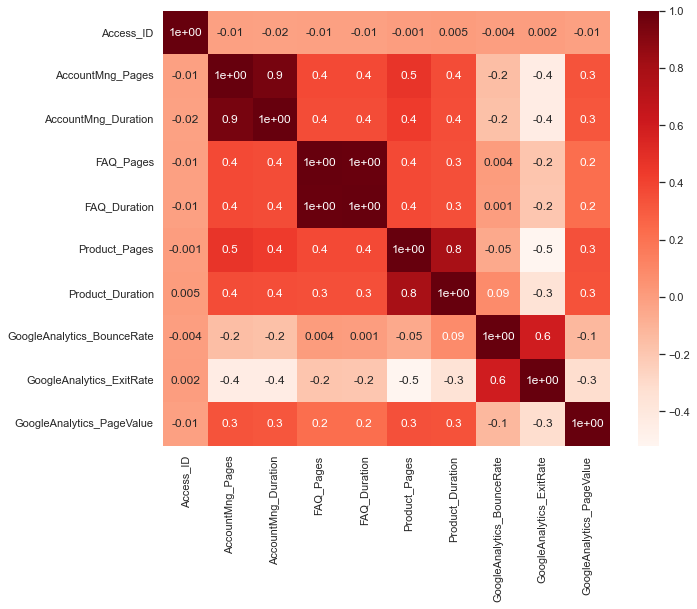

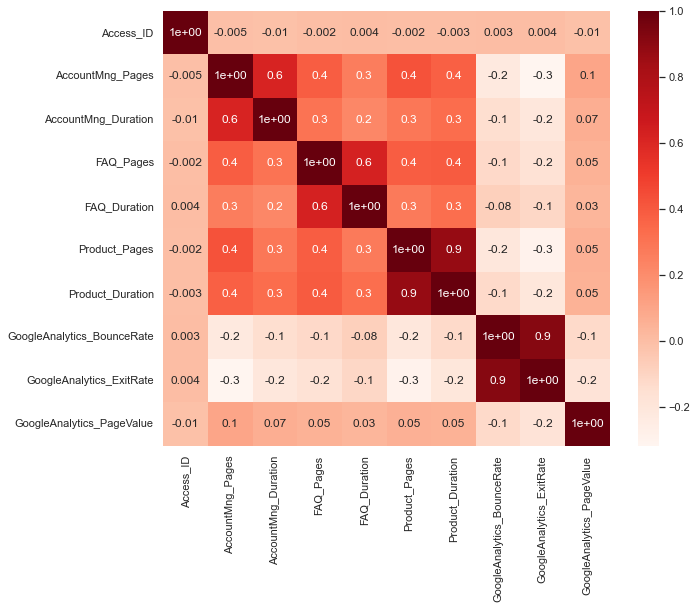

(None, None)

In [47]:
def corr_matrixes():
    return cor_heatmap(cor_spearman), cor_heatmap(cor_pearson)
corr_matrixes()

from spearman  we can only conclude that :
    - Either we drop FAQ_Duration or FAQ_Pages
    - Either we drop Product_Duration or Product_Pages
    - Either we drop AccountMng_Duration or AccountMng_Pages


from pearson we can only conclude that :
    - Either we keep GoogleAnalytics_ExitRate or GoogleAnalytics_BounceRate
    - Either we drop Product_Duration or Product_Pages


We can conclude that we either drop the column referent to (FAQ, AccountMng, Product) pages or duration 

In [48]:
to_remove_corr = ['Product_Pages', 'AccountMng_Duration', 'FAQ_Pages', 'GoogleAnalytics_ExitRate']
electedCorr = train_split.drop(to_remove_corr, axis = 1)


<a class="anchor" id="#chisquare">

### Chi Squared
    
</a>

In [49]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)

    print(result)

In [50]:
#CHI2
train_cat = train_copy[data_non_metric]
for var in train_cat:
    TestIndependence(train_cat[var],target,var)

OS_Chrome OS is NOT an important predictor. (Discard OS_Chrome OS from model)
OS_Fedora is NOT an important predictor. (Discard OS_Fedora from model)
OS_MacOSX is IMPORTANT for Prediction
OS_Other is NOT an important predictor. (Discard OS_Other from model)
OS_Ubuntu is NOT an important predictor. (Discard OS_Ubuntu from model)
OS_Windows is IMPORTANT for Prediction
OS_iOS is NOT an important predictor. (Discard OS_iOS from model)
Country_France is NOT an important predictor. (Discard Country_France from model)
Country_Germany is NOT an important predictor. (Discard Country_Germany from model)
Country_Italy is NOT an important predictor. (Discard Country_Italy from model)
Country_Other is NOT an important predictor. (Discard Country_Other from model)
Country_Portugal is NOT an important predictor. (Discard Country_Portugal from model)
Country_Spain is NOT an important predictor. (Discard Country_Spain from model)
Country_Switzerland is NOT an important predictor. (Discard Country_Switz

In [51]:
chi2 = ['OS_MacOSX','OS_Windows','Type_of_Visitor_Returner','Type_of_Visitor_New_Acces',
        'Browser_3','Browser_13',
        'Type_of_Traffic_10','Type_of_Traffic_12','Type_of_Traffic_13',
        'Type_of_Traffic_15','Type_of_Traffic_1',
        'Type_of_Traffic_2','Type_of_Traffic_3', 'Type_of_Traffic_7', 'Type_of_Traffic_8',
        'Month_3','Month_5','Month_10','Month_11','Month_12']

<a class="anchor" id="#mutualInfo">

### Mutual Information
    
</a>

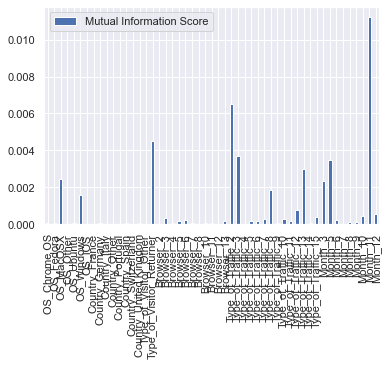

In [52]:
# feature selection
X = train_copy[data_non_metric]
val = mutual_info_classif(X, target, discrete_features=True)
labels = X.columns
df = pd.DataFrame({'Mutual Information Score': val}, index = labels)
df.plot.bar()
plt.show()

In [53]:
df[df['Mutual Information Score']>0.0002]

,Mutual Information Score
OS_MacOSX,0.002467
OS_Windows,0.001579
Type_of_Visitor_Returner,0.004528
Browser_3,0.000338
Browser_6,0.000224
Type_of_Traffic_2,0.006488
Type_of_Traffic_3,0.003703
Type_of_Traffic_7,0.000270
Type_of_Traffic_8,0.001845
Type_of_Traffic_10,0.000298


<a class="anchor" id="#rfe">

### RFE

</a>

- RFE using random forest:

In [54]:
train_split

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,...,Type_of_Traffic_15,Month_3,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,102863333,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103117814,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103201891,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,103226087,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,103234445,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,798314158,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9996,798339820,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,798371242,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#data.drop('Access_ID', axis = 1, inplace = True)#no of features
#nof_list=np.arange(1,61)            
#high_score=0
#Variable to store the optimum features
#nof=0           
#score_list =[]


#for n in range(len(nof_list)):
#    print(nof_list[n])
#    X_train, X_test, y_train, y_test = train_test_split(train_split,target, test_size = 0.3,
#                                                        random_state = 15)

#    model = RandomForestClassifier()
#    rfe = RFE(model,n_features_to_select=nof_list[n])
#    X_train_rfe = rfe.fit_transform(X_train,y_train)
#    X_test_rfe = rfe.transform(X_test)
#    model.fit(X_train_rfe,y_train)
    
#    score = model.score(X_test_rfe,y_test)
#    score_list.append(score)
    
#    if(score>high_score):
#        high_score = score
#        nof = nof_list[n]
#print("Optimum number of features: %d" %nof)
#print("Score with %d features: %f" % (nof, high_score))

In [56]:
#model = RandomForestClassifier()
#rfe = RFE(estimator = model, n_features_to_select = 16)
#X_rfe = rfe.fit_transform(train_split, y = target)
#rfe_features = pd.Series(rfe.support_, index = train_split.columns.to_list())


<a class="anchor" id="#lasso">

### LassoCV
    
</a>

In [57]:
reg = LassoCV()
reg.fit(train_copy[metric_features], target) 
coef = pd.Series(reg.coef_, index = metric_features)
print("Lasso picked "+ str(sum(coef != 0 )) + " variables and eliminated other " + str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated other 4 variables


<a class="anchor" id="#ridge">

### RidgeCV
    
    
</a>

In [58]:
ridge = RidgeCV()
ridge.fit(train_split[metric_features], target)
coef = pd.Series(ridge.coef_, index = metric_features)
print("Lasso picked "+ str(sum(coef != 0 )) + " variables and eliminated other " + str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated other 0 variables


<a class="anchor" id="#finalfeat">

### Final Feature Selection
    
    
</a>

BASED ON ALL FEATURE SELECTION TECHNIQUES 

In [59]:
selected_features = ['Product_Pages', 'AccountMng_Pages', 'FAQ_Pages','GoogleAnalytics_PageValue','GoogleAnalytics_BounceRate','OS_MacOSX',
                     'OS_Windows','Type_of_Visitor_Returner','Browser_3','Type_of_Traffic_10','Type_of_Traffic_12',
                    'Type_of_Traffic_13','Type_of_Traffic_15','Type_of_Traffic_2','Type_of_Traffic_3', 'Type_of_Traffic_7', 
                     'Type_of_Traffic_8','Type_of_Traffic_9','Month_3','Month_5','Month_10','Month_11','Month_12']





BASED ON RFE FEATURES 

In [60]:
selected_features_rfe_chi2 = ['AccountMng_Duration', 'AccountMng_Pages', 'GoogleAnalytics_PageValue', 'GoogleAnalytics_ExitRate', 'Product_Pages', 'Product_Duration',
                         'GoogleAnalytics_BounceRate','Browser_3','Type_of_Traffic_10','Type_of_Traffic_12',
                    'Type_of_Traffic_13','Type_of_Traffic_15','Type_of_Traffic_2','Type_of_Traffic_3', 'Type_of_Traffic_7', 
                     'Type_of_Traffic_8','Type_of_Traffic_9','Month_3','Month_5','Month_10','Month_11','Month_12']


#selected_features_rfe = rfe_features[rfe_features==True].index
#selected_features_rfe = selected_features_rfe.to_list()
#selected_features_rfe.remove('Access_ID')

In [61]:
#data without outliers 
data = train_split
#data with outliers 
data_o = df_outliers.drop('Buy', axis = 1)



<a class="anchor" id="#traintestsplit">

### Train Test Split
    
</a>



In [62]:
X = data[selected_features_rfe_chi2]
y = target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [63]:
X_outliers= data_o[selected_features_rfe_chi2]
y_outliers = df_outliers['Buy']
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=15, stratify=y_outliers)

<a class="anchor" id="#scaling">

### Scaling 
    
</a>



##### MinMax

In [64]:
min_max = MinMaxScaler().fit(X_train)
min_max_X_train = min_max.transform(X_train) 
min_max_X_val = min_max.transform(X_val) 

#### MinMax[-1,1]

In [65]:
min_max1 = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
min_max1_X_train = min_max1.transform(X_train) 
min_max1_X_val = min_max1.transform(X_val) 

#### Standard

In [66]:
standard = StandardScaler().fit(X_train)
standard_X_train = standard.transform(X_train) 
standard_X_val = standard.transform(X_val) 

#### Robust

In [67]:
robust = RobustScaler().fit(X_train)
robust_X_train = robust.transform(X_train) 
robust_X_val = robust.transform(X_val) 

robust_o = RobustScaler().fit(X_train_o)
robust_X_train_o = robust.transform(X_train_o) 
robust_X_val_o = robust.transform(X_val_o) 

<a class="anchor" id="#modelling">

## Models

</a>

<a class="anchor" id="#Accuracy">

### Accuracy Scores comparison

</a>

In [68]:
# accuracies =  [accuracy_score(y_val, lr.predict(robust_X_val)), 
#               accuracy_score(y_val, nb.predict(robust_X_val)), 
#               accuracy_score(y_val, kn.predict(robust_X_val)),
#               accuracy_score(y_val, dt.predict(robust_X_val)), 
#               accuracy_score(y_val, nn.predict(robust_X_val)), 
#               accuracy_score(y_val, bg1.predict(robust_X_val)),
#               accuracy_score(y_val, bg2.predict(robust_X_val)),
#               accuracy_score(y_val, ab.predict(robust_X_val)), 
#               accuracy_score(y_val, rf.predict(robust_X_val)), 
#               accuracy_score(y_val, gb.predict(robust_X_val)),
#               accuracy_score(y_val, svm.predict(robust_X_val))]
# models = ['lr','nb','kn','dt','nn','bg1','bg2','ab','rf','gb','svm']
# data_acc_tuples = list(zip(models,accuracies))
# data_acc = pd.DataFrame(data_acc_tuples)
# data_acc = data_acc.sort_values(1)
# plt.title("Accuracy scores using RobustScaler")
# plt.bar(data_acc[0], data_acc[1])
# plt.ylim(0.5,1)
# plt.show()

<a class="anchor" id="#F1">

### F1 Scores comparison

</a>

In [69]:
# lr = LogisticRegression(random_state = 15,solver='liblinear').fit(robust_X_train, y_train)
# nb = GaussianNB().fit(robust_X_train, y_train)
# kn = KNeighborsClassifier().fit(robust_X_train, y_train)
# dt = DecisionTreeClassifier(random_state = 15).fit(robust_X_train, y_train)
# nn = MLPClassifier(max_iter = 5000, random_state = 15).fit(robust_X_train, y_train)
# bg1 = BaggingClassifier(random_state = 15, base_estimator= ExtraTreesClassifier()).fit(robust_X_train, y_train)
# bg2 = BaggingClassifier(random_state = 15, base_estimator= nn).fit(robust_X_train, y_train)
# ab = AdaBoostClassifier(random_state = 15).fit(robust_X_train, y_train)
# rf = RandomForestClassifier(random_state = 15).fit(robust_X_train, y_train)
# gb = GradientBoostingClassifier(random_state = 15).fit(robust_X_train, y_train)
# svm = SVC(random_state=15).fit(robust_X_train, y_train)


In [70]:
# accuracies = [f1_score(y_val, lr.predict(robust_X_val)), 
#               f1_score(y_val, nb.predict(robust_X_val)), 
#               f1_score(y_val, kn.predict(robust_X_val)),
#               f1_score(y_val, dt.predict(robust_X_val)), 
#               f1_score(y_val, nn.predict(robust_X_val)), 
#               f1_score(y_val, bg1.predict(robust_X_val)),
#               f1_score(y_val, bg2.predict(robust_X_val)),
#               f1_score(y_val, ab.predict(robust_X_val)), 
#               f1_score(y_val, rf.predict(robust_X_val)), 
#               f1_score(y_val, gb.predict(robust_X_val)),
#               f1_score(y_val, svm.predict(robust_X_val))]
# models = ['lr','nb','kn','dt','nn','bg1','bg2','ab','rf','gb','svm']
# data_tuples = list(zip(models,accuracies))
# data = pd.DataFrame(data_tuples)
# data = data.sort_values(1)
# plt.bar(data[0], data[1])
# plt.ylim(0.5,0.7)
# plt.show()

By checking each model's f1_score with a robust scaler(the one that reached the highest value with the neural network, since both gradient boost and random forest were unaffected by the scaling) 




we determined that we would only tune the top 3 models, which are the MLPClassifier, GradientBoostClassifier and RandomForestClassifier

We will used two functions imported from practical classes to calculate the best parameters to use each is model return_f1_score and return_Results

## StratifiedKFold

Our StratifiedKfold for cross validation is defined here

In [71]:
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3,random_state = 15)


<a class="anchor" id="#rf">

### Random Forest

</a>

In [72]:
# from sklearn.model_selection import RepeatedStratifiedKFold

# parameters = {'n_estimators': [225,250,450], 
#               'max_depth' :[6,7,8],
#              'class_weight' : [{0:1,1:2}, 'balanced'],
#              'criterion':['gini', 'entropy']}
# rforest_clf = RandomForestClassifier(random_state = 15)
# rforest_cv = GridSearchCV(estimator=rforest_clf, param_grid=parameters, scoring='f1', cv=10, n_jobs=-1)
# rforest_cv.fit(X_train, y_train)


In [73]:
# print('Best parameters set found:',rforest_cv.best_params_)
# print('Score with best parameters:',rforest_cv.best_score_)


Grid Search recommended max_depth 8 as the best parameter afer doing hyperparameter tunning with lower and higher values, however our best score on kaggle with random forest was achieved with max depth = 6

In [74]:
#Best parameters
rndf_clf = RandomForestClassifier(n_estimators = 450, max_depth =6,class_weight = {0:1,1:2},
                                criterion = 'gini', random_state = 15)
rndf_clf.fit(X_train_o,y_train_o)
#Test Results 
metrics(rndf_clf,X_train_o, y_train_o, X_val_o, y_val_o)

print("\n")


print(f1_score(y_train_o, rndf_clf.predict(X_train_o)))

print(f1_score(y_val_o, rndf_clf.predict(X_val_o)))
#metrics_no_split(rndf_clf,X,y)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.9055

Balanced Accuracy Score: 0.8435

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6757
           1       0.68      0.75      0.71      1242

    accuracy                           0.91      7999
   macro avg       0.81      0.84      0.83      7999
weighted avg       0.91      0.91      0.91      7999


Confusion Matrix:
[[6307  450]
 [ 306  936]]

Specificity:

                        0  0.7536231884057971
                        1  0.9334023975136895

macro avg: 0.8435127929597432
None
________________________________________________________________________________

In [74]:
# sub = test_copy.copy()
# sub['Buy'] = rndf_clf.predict(test_copy[selected_features_rfe_chi2])
# sub = sub[['Access_ID','Buy']]
# sub.set_index('Access_ID',inplace = True)

# compression_opts = dict(method='zip',
#                         archive_name='sub.csv')  
# sub.to_csv('testRF.zip',
#           compression=compression_opts)  


<a class="anchor" id="#gradBoost">

### Gradient Boost Classifier

</a>

In [75]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         models[str(value)] = GradientBoostingClassifier(n_estimators = value, random_state = 15)      
#     return models

# models = get_models([20,30,50,100,150,200,500,600])
# return_results(models)

n_estimators = 200,100, 50

In [76]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         models[str(value)] = GradientBoostingClassifier(learning_rate = value,n_estimators = 200, random_state = 15)      
#     return models

# models = get_models([0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1.0])
# return_results(models)

rlearning_rate = 0.1

In [77]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         models[str(value)] = GradientBoostingClassifier(subsample = value, random_state = 15)      
#     return models

# models = get_models([0.2,0.4,0.6,0.8,1.0])
# return_results(models)

subsample = 0.8, 0.1

In [78]:
# def get_models(values):
#     models = dict()
#     for value in values:
#         models[str(value)] = GradientBoostingClassifier(max_features = value, random_state = 15)      
#     return models

# models = get_models([2,0.5,'sqrt','log2',None])
# return_results(models)

max_features = 0.5, sqrt , log, none

In [ ]:
# parameters = {'n_estimators': list(range(100,150)), 
#               'learning_rate' :list(np.linspace(0.1, 0.9, 5, endpoint=True)),
#              'subsample' : [0.1,0.2,0.3,0.4,0.5,0.8],
#              'max_features':[None,0.5,'sqrt','log2']}
# grboost_clf = GradientBoostingClassifier(random_state = 15)
# grboost_cv = GridSearchCV(estimator=grboost_clf, param_grid=parameters, scoring='f1', cv=10, n_jobs=-1)
# grboost_cv.fit(X_train, y_train)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\joblib\parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\joblib\_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\concurrent\futures\_base.py", line 439, in result
    self._condition.wait(timeout)
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\sklearn\model_selection\_search.py", line 710, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\sklearn\model_selection\_search.py", line 1151, in _run_search
    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\IPython\core\interactiveshell.py", line 3458, in run_code
    self.showtraceback(running_compiled_code=True)
  File "C:\Users\silva\anaconda3\envs\dsaa\lib\site-packages\IPython\core\interactiveshell.py", line 2063, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype

In [79]:
# print('Best parameters set found:',grboost_cv.best_params_)
# print('Score with best parameters:',grboost_cv.best_score_)

In [81]:
gb_clf = GradientBoostingClassifier(n_estimators = 100,max_features =None,subsample = 0.8, learning_rate
                                   = 0.1,random_state = 15)
gb_clf.fit(X_train_o, y_train_o)
metrics(gb_clf,X_train_o, y_train_o,X_val_o,y_val_o)


print(f1_score(y_train_o, gb_clf.predict(X_train_o)))

print(f1_score(y_val_o, gb_clf.predict(X_val_o)))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.9226

Balanced Accuracy Score: 0.8188

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6757
           1       0.80      0.67      0.73      1242

    accuracy                           0.92      7999
   macro avg       0.87      0.82      0.84      7999
weighted avg       0.92      0.92      0.92      7999


Confusion Matrix:
[[6550  207]
 [ 412  830]]

Specificity:

                        0  0.6682769726247987
                        1  0.9693651028562972

macro avg: 0.8188210377405479
None
________________________________________________________________________________

<a class="anchor" id="#NN">

### Neural Network 

</a>


In [ ]:

# parameters = {'hidden_layer_sizes': [(100,), (50,),(20,)],
#         'activation': ['relu', 'logistic','tanh', 'dentity’'],
#         'solver': ['sgd', 'adam', 'lbfgs’'],
#         'learning_rate_init': [0.01, 0.001, 0.0001],
#         'learning_rate': ['constant','adaptive', 'invscaling’']}
# mlp_ = MLPClassifier(random_state = 15)
# mlp_cv = GridSearchCV(estimator=mlp_, param_grid=parameters, scoring='f1', cv=10, n_jobs=-1)
# mlp_cv.fit(robust_X_train, y_train)


In [ ]:
# print('Best parameters set found:',mlp_cv.best_params_)
# print('Score with best parameters:',mlp_cv.best_score_)

In [ ]:
# mlp_clf = MLPClassifier(activation = 'tanh', hidden_layer_sizes=(100,), learning_rate = 'constant', learning_rate_init = 0.01 ,solver = 'sgd', random_state = 15)
# mlp_clf.fit(robust_X_train, y_train)

In [ ]:
# metrics(mlp_clf,robust_X_train, y_train, robust_X_val, y_val)

In [ ]:
# sub1 = test_copy.copy()
# sub1['Buy'] = mlp_clf.predict(test_copy[selected_features_rfe_chi2])
# sub1 = sub1[['Access_ID','Buy']]
# sub1.set_index('Access_ID',inplace = True)

# compression_opts = dict(method='zip',
#                         archive_name='testNN.csv')  
# # sub1.to_csv('testNN.zip',
#           compression=compression_opts) 
# 

<a class="anchor" id="#stacking">

### Stacking

</a>


In [ ]:
# estimators = [('nn', MLPClassifier(max_iter = 5000,random_state = 15)),
# #               ('gb', GradientBoostingClassifier(random_state = 15)),
#               ('rf', RandomForestClassifier(random_state = 15))]

In [ ]:
# st = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(random_state =15)).fit(robust_X_train, y_train)

In [ ]:
# accuracies = [f1_score(y_val, lr.predict(robust_X_val)), 
#              f1_score(y_val, nb.predict(robust_X_val)), 
#              f1_score(y_val, kn.predict(robust_X_val)),
#              f1_score(y_val, dt.predict(robust_X_val)), 
#              f1_score(y_val, nn.predict(robust_X_val)), 
#              f1_score(y_val, bg1.predict(robust_X_val)),
#              f1_score(y_val, bg2.predict(robust_X_val)),
#              f1_score(y_val, ab.predict(robust_X_val)), 
#              f1_score(y_val, rf.predict(robust_X_val)), 
#              f1_score(y_val, gb.predict(robust_X_val)),
#              f1_score(y_val, svm.predict(robust_X_val)),
#              f1_score(y_val, st.predict(robust_X_val))]
# models = ['lr','nb','kn','dt','nn','bg1','bg2','ab','svm','rf','gb','st']
# data_tuples = list(zip(models,accuracies))
# data = pd.DataFrame(data_tuples)
# data = data.sort_values(1)
# plt.bar(data[0], data[1])
# plt.ylim(0.5,0.7)
# plt.show()

In [ ]:
# print(f1_score(y_train, nn.predict(robust_X_train)))
# print(f1_score(y_val, nn.predict(robust_X_val)))

## SMOTE

In [ ]:
# smote = SMOTE(sampling_strategy = 'not majority')
# robust_X_train, y_train = smote.fit_resample(robust_X_train,y_train)

In [ ]:
# lr = LogisticRegression(random_state = 15,solver='liblinear').fit(robust_X_train, y_train)
# nb = GaussianNB().fit(robust_X_train, y_train)
# kn = KNeighborsClassifier().fit(robust_X_train, y_train)
# dt = DecisionTreeClassifier(random_state = 15).fit(robust_X_train, y_train)
# nn = MLPClassifier(max_iter = 5000, random_state = 15).fit(robust_X_train, y_train)
# bg1 = BaggingClassifier(random_state = 15, base_estimator= ExtraTreesClassifier()).fit(robust_X_train, y_train)
# bg2 = BaggingClassifier(random_state = 15, base_estimator= nn).fit(robust_X_train, y_train)
# ab = AdaBoostClassifier(random_state = 15).fit(robust_X_train, y_train)
# rf = RandomForestClassifier(random_state = 15).fit(robust_X_train, y_train)
# gb = GradientBoostingClassifier(random_state = 15).fit(robust_X_train, y_train)
# svm = SVC(random_state=15).fit(robust_X_train, y_train)

In [ ]:
# accuracies =  [accuracy_score(y_val, lr.predict(robust_X_val)), 
#               accuracy_score(y_val, nb.predict(robust_X_val)), 
#               accuracy_score(y_val, kn.predict(robust_X_val)),
#               accuracy_score(y_val, dt.predict(robust_X_val)), 
#               accuracy_score(y_val, nn.predict(robust_X_val)), 
#               accuracy_score(y_val, bg1.predict(robust_X_val)),
#               accuracy_score(y_val, bg2.predict(robust_X_val)),
#               accuracy_score(y_val, ab.predict(robust_X_val)), 
#               accuracy_score(y_val, rf.predict(robust_X_val)), 
#               accuracy_score(y_val, gb.predict(robust_X_val)),
#               accuracy_score(y_val, svm.predict(robust_X_val))]
# models = ['lr','nb','kn','dt','nn','bg1','bg2','ab','rf','gb','svm']
# data_acc_tuples = list(zip(models,accuracies))
# data_acc = pd.DataFrame(data_acc_tuples)
# data_acc = data_acc.sort_values(1)
# plt.title("Accuracy scores in the validation set with SMOTE")
# plt.bar(data_acc[0], data_acc[1])
# plt.ylim(0.5,1)
# plt.show()

In [ ]:
# accuracies =  [accuracy_score(y_train, lr.predict(robust_X_train)), 
#               accuracy_score(y_train, nb.predict(robust_X_train)), 
#               accuracy_score(y_train, kn.predict(robust_X_train)),
#               accuracy_score(y_train, dt.predict(robust_X_train)), 
#               accuracy_score(y_train, nn.predict(robust_X_train)), 
#               accuracy_score(y_train, bg1.predict(robust_X_train)),
#               accuracy_score(y_train, bg2.predict(robust_X_train)),
#               accuracy_score(y_train, ab.predict(robust_X_train)), 
#               accuracy_score(y_train, rf.predict(robust_X_train)), 
#               accuracy_score(y_train, gb.predict(robust_X_train)),
#               accuracy_score(y_train, svm.predict(robust_X_train))]
# models = ['lr','nb','kn','dt','nn','bg1','bg2','ab','rf','gb','svm']
# data_acc_tuples = list(zip(models,accuracies))
# data_acc = pd.DataFrame(data_acc_tuples)
# data_acc = data_acc.sort_values(1)
# plt.title("Accuracy scores in the train set with SMOTE")
# plt.bar(data_acc[0], data_acc[1])

# plt.ylim(0.5,1)
# plt.show()

<a class="anchor" id="#roc">

## ROC curve

</a>

In [ ]:
# LR = lr.predict_proba(robust_X_val)
# NB = nb.predict_proba(robust_X_val)
# KNN = kn.predict_proba(robust_X_val)
# DT = dt.predict_proba(robust_X_val)
# NN = nn.predict_proba(robust_X_val)
# BG1 = bg1.predict_proba(robust_X_val)
# BG2 = bg2.predict_proba(robust_X_val)
# AB = ab.predict_proba(robust_X_val)
# RF = rf.predict_proba(robust_X_val)
# GB = gb.predict_proba(robust_X_val)
# ST = st.predict_proba(robust_X_val)

# fpr_LR,tpr_LR, treshold_LR = roc_curve(y_val, LR[:,1])
# fpr_NB,tpr_NB, treshold_NB  = roc_curve(y_val, NB[:,1])
# fpr_KNN,tpr_KNN, treshold_KNN  = roc_curve(y_val, KNN[:,1])
# fpr_DT,tpr_DT, treshold_DT  = roc_curve(y_val, DT[:,1])
# fpr_NN,tpr_NN, treshold_NN  = roc_curve(y_val, NN[:,1])
# fpr_BG1,tpr_BG1, treshold_BG1  = roc_curve(y_val, BG1[:,1])
# fpr_BG2,tpr_BG2, treshold_BG2  = roc_curve(y_val, BG2[:,1])
# fpr_AB,tpr_AB, treshold_AB  = roc_curve(y_val, AB[:,1])
# fpr_RF,tpr_RF, treshold_RF  = roc_curve(y_val, RF[:,1])
# fpr_GB,tpr_GB, treshold_GB  = roc_curve(y_val, GB[:,1])
# fpr_ST,tpr_ST, treshold_ST  = roc_curve(y_val, ST[:,1])

# plt.plot(fpr_LR,tpr_LR,label="ROC Curve LR")
# plt.plot(fpr_NB,tpr_NB, label="ROC Curve NB")
# plt.plot(fpr_KNN,tpr_KNN, label="ROC Curve KNN")
# plt.plot(fpr_DT,tpr_DT, label="ROC Curve DT")
# plt.plot(fpr_NN,tpr_NN, label="ROC Curve NN")
# plt.plot(fpr_BG1,tpr_BG1, label="ROC Curve BG1")
# plt.plot(fpr_BG2,tpr_BG2,  label="ROC Curve BG2")
# plt.plot(fpr_AB,tpr_AB,  label="ROC Curve AB")
# plt.plot(fpr_RF,tpr_RF,label="ROC Curve RF")
# plt.plot(fpr_GB,tpr_GB, label="ROC Curve GB")
# plt.plot(fpr_ST,tpr_ST, label="ROC Curve ST")

# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.legend()
# plt.show()

<a class="anchor" id="#kaggle">

## Kaggle Submission

</a>


In [ ]:
sub = test_copy.copy()
sub['Buy'] = gb_clf.predict(test_copy[selected_features_rfe_chi2])
sub = sub[['Access_ID','Buy']]
sub.set_index('Access_ID',inplace = True)

compression_opts = dict(method='zip',
                        archive_name='testGB.csv')  
sub.to_csv('testGB.zip',
          compression=compression_opts)  